<a href="https://colab.research.google.com/github/shwets1503/Sales_Prediction/blob/master/Predicting_customer_satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer Satisfaction - Ecommerce Data


Olist has released a dataset of 100k orders made between 2016 and 2018. This is the model to predict what's the score a customer will give for an order.

# 1. Business Understanding
Let's say your manager asked you:

"What is the probable score that we getting from customers?"

Our problem is to find a way to estimate, based on data about the product and order, what will be the customer review score.

### The hypothesis
Our main hypothesis is that the product and how the order was fulfilled might influence the customer review score. Keeping in mind that each feature we create is a new hypothesis we are testing.

### Designing an Experiment
To answer that question we must collect data from each order up to delivery phase. With that, we should implement a model that estimates what will be the score given by the customer at the review phase.

  Purchase --> Transport --> Delivery --> &emsp;Review<br>
 &emsp;&emsp;&emsp;[ Extract Features ]&emsp;&emsp;&emsp;&emsp;&emsp;[ Make Prediction ]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Libraries


In [22]:
import numpy as np 
import pandas as pd 

# Visualization Libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

# DateTime Libraries
import datetime as dt
# To consider Brazilian calendar and holidays
!pip install workalendar --quiet
from workalendar.america import Brazil

# For model building and testing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 2. Data Understanding

### Importing Datasets

In [5]:
orders_df = pd.read_csv('../content/drive/My Drive/sales_data2/olist_orders_dataset.csv', engine='python')
order_items = pd.read_csv('../content/drive/My Drive/sales_data2/olist_order_items_dataset.csv', engine='python')
order_reviews = pd.read_csv('../content/drive/My Drive/sales_data2/olist_order_reviews_dataset.csv', engine='python')
products = pd.read_csv('../content/drive/My Drive/sales_data3/olist_products_dataset.csv', engine='python')
product_category = pd.read_csv('../content/drive/My Drive/sales_data3/product_category_name_translation.csv', engine='python')
customer = pd.read_csv('../content/drive/My Drive/sales_data/customers_dataset.csv', engine='python')
payments = pd.read_csv('../content/drive/My Drive/sales_data2/olist_order_payments_dataset.csv', engine='python')

In [6]:
# Merging categories data with english translations and dropping that column 
categories = pd.merge(products, product_category,how ='left', left_on ='product_category_name', right_index = True, suffixes=(None, '_eng')).drop('product_category_name', axis=1)

In [7]:
# Merging required datasets
orders = pd.merge(order_reviews, order_items, how='left', on='order_id')
orders = pd.merge(orders, orders_df, how='left', on='order_id')
orders = pd.merge(orders, customer, how='left', on='customer_id')
orders = pd.merge(orders, categories, how='left', on='product_id')

In [8]:
# Dataset after Merging
orders.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_eng
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,sports_leisure
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,sports_leisure
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP,47.0,493.0,1.0,245.0,19.0,14.0,14.0,computers_accessories
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,computers_accessories
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,garden_tools


Although some items seem duplicated their order_item_id indicates multiple orders of same item, so not dropping them.

In [9]:
# Shape of the dataset after merging
orders.shape

(114100, 32)

# 3. Data Cleaning

In [10]:
# Converting necessary columns to datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp).dt.dayofweek
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date) .dt.date 

In [11]:
# Filtering useful columns
orders = orders[['order_status', 'price', 'order_purchase_timestamp', 
                 'order_approved_at','order_estimated_delivery_date',
                 'order_delivered_customer_date',
                 'freight_value', 'order_item_id', 
                'customer_state', 
                 'product_category_name_eng', 'product_name_lenght', 'product_description_lenght', 
                 'product_photos_qty', 'review_score']]

### Checking for null values and data types


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114100 entries, 0 to 114099
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_status                   114100 non-null  object 
 1   price                          113322 non-null  float64
 2   order_purchase_timestamp       114100 non-null  int64  
 3   order_approved_at              113938 non-null  object 
 4   order_estimated_delivery_date  114100 non-null  object 
 5   order_delivered_customer_date  110847 non-null  object 
 6   freight_value                  113322 non-null  float64
 7   order_item_id                  113322 non-null  float64
 8   customer_state                 114100 non-null  object 
 9   product_category_name_eng      111686 non-null  object 
 10  product_name_lenght            111710 non-null  float64
 11  product_description_lenght     111710 non-null  float64
 12  product_photos_qty            

There are 9 columns with null values.

## Feature Engineering

### Creating a Custom Transformer for FeatEng
We need to guarantee that we are apply exactly the same transformation to new/unseen data. To do that we will create custom transformers using scikit-learn BaseEstimator.



### Features Hypotesis
**Working Days Estimated Delivery Time**<br>
Getting the days between order approval and estimated delivery date. A customer might be unsatisfied if he this time is long.

**Working Days Actual Delivery Time**<br>
Getting the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product quicker.

**Working Days Delivery Time** <br>
The difference between the actual and estimated date. If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline.

**Is Late**<br>
Binary variable indicating if the order was delivered after the estimated date.

**Average Product Value**<br>
Cheaper products might have lower quality, leaving customers unhappy.

**Total Order Value**<br>
If a customer spends more, he might expect more.

**Order Freight Ratio**<br>
If a customer pays more for freight, he might expect a better service.

**Purchase Day of Week**<br>
Does it affect how happy are the customers?

In [13]:
cal = Brazil()

from sklearn.base import BaseEstimator, TransformerMixin
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # Calculate the estimated delivery time and actual delivery time in working days. 
        # This would allow us to exclude hollidays that could influence delivery times.
        # If the order_delivered_customer_date is null, it returns 0.
        df['wd_estimated_delivery_days'] = df.apply(lambda x: cal.get_working_days_delta(x.order_approved_at, 
                                                                                      x.order_estimated_delivery_date), axis=1)
        df['wd_actual_delivery_days'] = df.apply(lambda x: cal.get_working_days_delta(x.order_approved_at, 
                                                                                   x.order_delivered_customer_date), axis=1)

        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['wd_delivery_estimated_diff'] = df.wd_actual_delivery_days - df.wd_estimated_delivery_days


        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        # Calculate the average product value.
        df['average_product_value'] = df.price / df.order_item_id

        # Calculate the total order value
        df['total_order_value'] = df.price + df.freight_value
        
        # Calculate the order freight ratio.
        df['order_freight_ratio'] = df.freight_value / df.price
        
        # Calculate the order freight ratio.
        df['purchase_dayofweek'] = df.order_purchase_timestamp
                       
        # With that we can remove the timestamps from the dataset
        cols2drop = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        return df.values

# 4. Data Visualizations

## 4.1 Review score counts and product mean value as per review

In [14]:
items_reviews = pd.merge(order_reviews, order_items, how='left', on='order_id')
review_qty = items_reviews.groupby('review_score').size()
review_value = items_reviews.groupby('review_score')['price'].mean()

In [15]:
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Product mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Review Score')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40], tickmode = 'linear')
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1], tickmode = 'linear')
iplot(fig);

## 4.2 Difference between actual delivery time and estimated delivery time

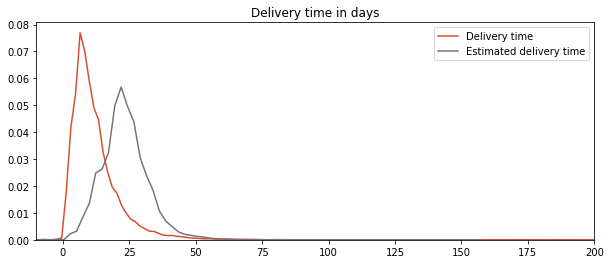

In [16]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
# Calculate differences in hours
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
orders_df['estimated_delivery_time'] = (orders_df['order_estimated_delivery_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
# Delivery estimated time and actual delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
plt.xlim(-10, 200)

ax1 = sns.kdeplot(orders_df['delivery_time'].dropna(), color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(orders_df['estimated_delivery_time'].dropna(), color="#7E7270", label='Estimated delivery time')

#5. Model Building

In [17]:
#Categrical features to pass down the categorical pipeline 
categorical_features = ['order_status', 'customer_state', 'product_category_name_eng']

#Numerical features to pass down the numerical pipeline 
numerical_features = ['price', 'freight_value', 'order_item_id', 'product_name_lenght', 'product_description_lenght', 
                 'product_photos_qty', 'order_purchase_timestamp',
                 'order_approved_at', 'order_estimated_delivery_date',
                 'order_delivered_customer_date']


#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ('imputer', SimpleImputer(strategy = 'most_frequent') ),                                
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ('attribs_adder', AttributesAdder() ),                             
                                  ('imputer', SimpleImputer(strategy = 'median') ),                   
                                  ( 'std_scaler', StandardScaler() ) ] )

#Combining numerical and categorical piepline into one full big pipeline horizontally using ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
       ('num', categorical_pipeline, categorical_features ),                                               
                                                  ('cat',numerical_pipeline, numerical_features )])

In [18]:
#Leave it as a dataframe becuase our pipeline is called on a 
#pandas dataframe to extract the appropriate columns, remember?
X = orders.drop('review_score', axis = 1)
#You can covert the target variable to numpy 
y = orders['review_score']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]

#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  
                                  ( 'model', LinearRegression() ) ] )

#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

In [19]:
y_pred

array([4.19869995, 4.17770386, 1.99703979, ..., 4.30172729, 4.08200073,
       4.4357605 ])

In [23]:
forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.2427031953014394

In [24]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[-1.6255188  -0.90090942 -0.75686646 ...  4.92672729  5.15914917
   5.22653198]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


In [25]:
# Choosing best classifier
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('full_pipeline', full_pipeline),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.489
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
model score: 0.450
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split

I will further do hyperparameter tuning and use Random Forest Classifier for better score.